#### General Notes
- `airline_sentiment` and possibly `airline_sentiment_confidence` are target columns (the latter cannot be in training data)
- Remove instances of `"@airline"` tags from text

#### How to handle each column
**Numerical Columns**
- `negativereason_confidence` -- fill missing data with 0
- `retweet_count` -- remove, almost 100% is just 0

**Categorical Columns**
- `negativereason` -- one-hot encode top K reasons +1 column for "other"
- `airline` -- remove or one-hot encode with "other" column
- `airline_sentiment_gold` -- remove, almost 100% missing data
- `name` -- remove, unique data
- `negative_reason_gold` -- remove, almost 100% missing data
- `tweet_location` -- remove or one-hot encode with "other" column

**Other Columns**
- `tweet_coord` -- remove, almost 100% missing data
- `user_timezone` -- remove, a lot of missing and correlates with location
- `tweet_created` -- convert to columns: day of year (sin/cos), day of week, time of day (sin/cos)
- `text` -- sklearn.feature_extraction.text -> CountVectorizer (?)


### **Libraries and helper functions**

In [11]:
# Add parent directory to system path for module imports
import sys
sys.path.append('..')

In [12]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from src.transformers import *

In [13]:
# Import classifiers and label encoder
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import LabelEncoder

In [14]:
# Importing features for model evaluation
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
# Function to load and split the data
def load_data():
    df = pd.read_csv('../data/Tweets.csv')
    df = df.drop(columns=['tweet_id'])
    df_train, df_test = train_test_split(df, test_size=0.1, stratify=df[['airline_sentiment']], random_state=0)

    X_train = df_train.drop(columns=['airline_sentiment', 'airline_sentiment_confidence'])
    y_train = df_train[['airline_sentiment']]

    X_test = df_test.drop(columns=['airline_sentiment', 'airline_sentiment_confidence'])
    y_test = df_test[['airline_sentiment']]

    return X_train, y_train, X_test, y_test

### **Pipeline**

In [ ]:
# Define columns for different preprocessing steps
columns_to_drop = ['retweet_count', 'airline_sentiment_gold', 'negativereason_gold', 'tweet_coord', 
                   'name', 'user_timezone', 'negativereason', 'negativereason_confidence']
columns_to_fill_zero = []
columns_to_fill_unknown = ['tweet_location']
columns_to_ohe = ['airline', 'tweet_location']


column_order_after_transform = \
    columns_to_fill_zero + columns_to_fill_unknown + ['airline', 'text', 'tweet_created']
column_idx = lambda c: column_order_after_transform.index(c)

preprocessor = Pipeline(steps=[
    ('drop', DropColumnTransformer(columns_to_drop)),
    ('fill_missing',
        ColumnTransformer(
            transformers=[
                ('fill_zero', SimpleImputer(strategy='constant', fill_value=0), columns_to_fill_zero),
                ('fill_other', SimpleImputer(strategy='constant', fill_value='Unknown'), columns_to_fill_unknown),
            ],
            remainder='passthrough')),
    ('encode', ColumnTransformer(transformers=[
        ('ohe', OneHotEncoder(
            handle_unknown='infrequent_if_exist',
            max_categories=10,
            sparse_output=False),
            list(map(column_idx, columns_to_ohe))),
        ('time', TimeTransformer(), list(map(column_idx, ['tweet_created']))),
        ('text', TextTransformer(), list(map(column_idx, ['text'])))
    ],
    remainder='passthrough'))
])

### **Data preparation**

In [ ]:
X_train, y_train, X_test, y_test = load_data()

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

le = LabelEncoder()
y_train_processed = le.fit_transform(y_train)
y_test_processed = le.transform(y_test)

/home/michal/miniconda3/envs/jupyter/lib/python3.13/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/michal/miniconda3/envs/jupyter/lib/python3.13/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


### **Classifiers**

Accuracy on training data: 0.7509
Accuracy on test data: 0.7206

Classification report for the test data:
              precision    recall  f1-score   support

    negative       0.77      0.89      0.83       918
     neutral       0.53      0.40      0.46       310
    positive       0.68      0.48      0.56       236

    accuracy                           0.72      1464
   macro avg       0.66      0.59      0.61      1464
weighted avg       0.70      0.72      0.71      1464



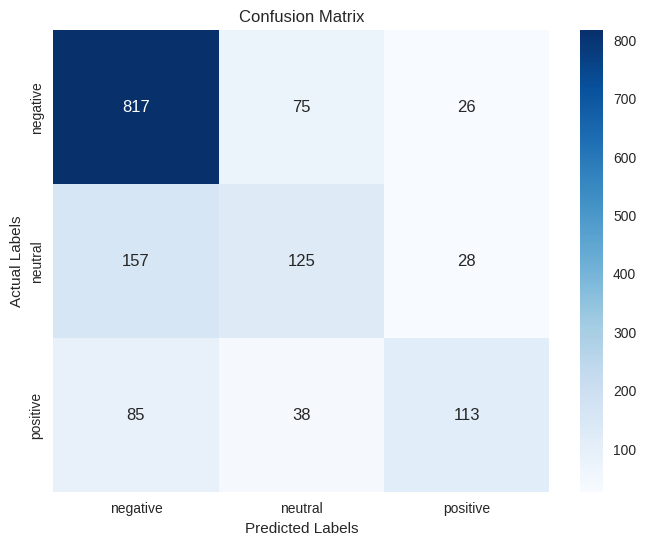

AUC (One-vs-Rest) on test data: 0.8393


np.float64(0.7052610405972074)

In [ ]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_processed, y_train_processed)

y_train_pred = clf.predict(X_train_processed)
train_accuracy = accuracy_score(y_train_processed, y_train_pred)
print(f"Accuracy on training data: {train_accuracy:.4f}")

y_test_pred = clf.predict(X_test_processed)
test_accuracy = accuracy_score(y_test_processed, y_test_pred)
print(f"Accuracy on test data: {test_accuracy:.4f}")
print("\nClassification report for the test data:")
print(classification_report(y_test_processed, y_test_pred, target_names=le.classes_))

cm = confusion_matrix(y_test_processed, y_test_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix')
plt.show()

y_test_prob = clf.predict_proba(X_test_processed)

auc = roc_auc_score(y_test_processed, y_test_prob, multi_class='ovr')
print(f"AUC (One-vs-Rest) on test data: {auc:.4f}")

test_f1 = f1_score(y_test_processed, y_test_pred, average='weighted')
test_f1


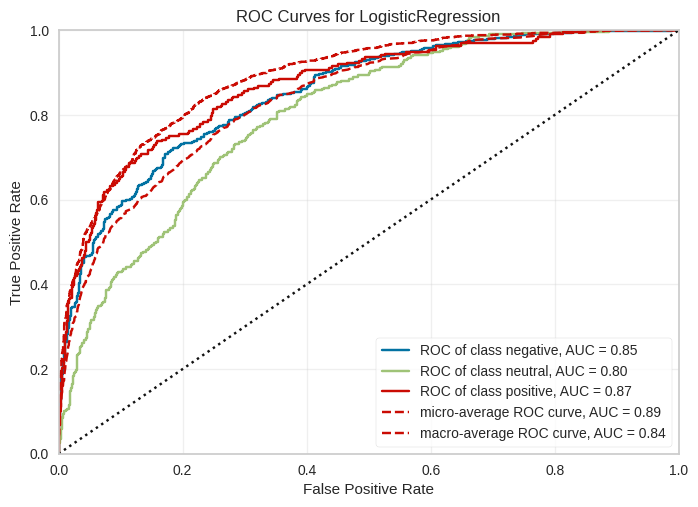

<Axes: title={'center': 'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [ ]:
from yellowbrick.classifier import ROCAUC
import matplotlib.pyplot as plt

visualizer = ROCAUC(
    clf,
    classes=le.classes_,
    cmap='prism',
    linewidth=1.5
)

visualizer.fit(X_train_processed, y_train_processed)
visualizer.score(X_test_processed, y_test_processed)

plt.title("ROC Curves with Distinct Colors")
plt.grid(alpha=0.3)
visualizer.show()